# KDP Estimation Methods Comparison

Different KDP (Specific Differential Phase) estimation methods from PyArt and CSU radar tools, the Linear Programming (LP) and Maesaka methods from PyArt, and the Bringi method from CSU, are analyzed.

In [1]:
import pyart
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
import geopandas as gpd
from csu_radartools import csu_kdp


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/braut/analysis-env2/share/proj failed
/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hour = '19'
day = '25'
month = '08'
year = '2022'

glob_str = f'/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/{year}{month}/gucxprecipradarcmacS2.c1.{year}{month}{day}.{hour}*'

files = sorted(glob.glob(glob_str))

/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


(-20.0, 20.0)

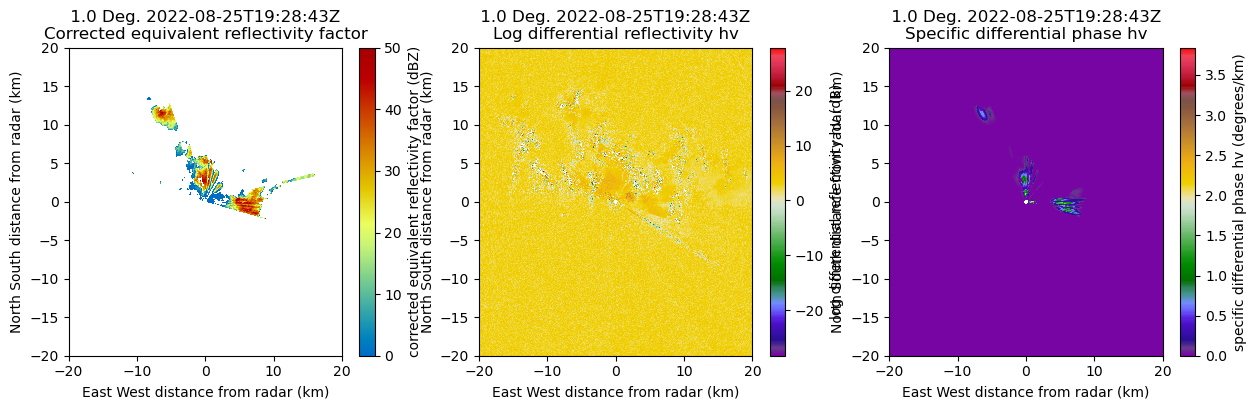

In [18]:
radar_pyart = pyart.io.read(files[4])

figure = plt.figure(figsize=(15, 4))

ax1=plt.subplot(1, 3, 1)
display = pyart.graph.RadarDisplay(radar_pyart)
ax1= display.plot('corrected_reflectivity', vmin=0, vmax=50) #DBZ corrected_reflectivity
plt.xlim(-20, 20)
plt.ylim(-20, 20)

ax2 = plt.subplot(1, 3, 2)
ax2= display.plot('ZDR', cmap='pyart_Carbone42') #ZDR
plt.xlim(-20, 20)
plt.ylim(-20, 20)

ax3 = plt.subplot(1, 3, 3)
ax3= display.plot('filtered_corrected_specific_diff_phase', cmap='pyart_Carbone42') #KDP
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [19]:
PHIDP_LP, KDP_LP = pyart.correct.phase_proc_lp(radar_pyart, 0.0, ncp_field='NCP', refl_field='DBZ', rhv_field='RHOHV', phidp_field='PHIDP')
radar_pyart.add_field('PHIDP_LP', PHIDP_LP)
radar_pyart.add_field('KDP_LP', KDP_LP)

# KDP Estimation Methods Comparison

In [20]:
# create path
year, month, day, hour = '2022', '08', '25', '19'
data_path = f'/gpfs/wolf2/arm/atm124/world-shared/gucxprecipradarcmacS2.c1/ppi/{year}{month}/gucxprecipradarcmacS2.c1.{year}{month}{day}.{hour}*'
files = sorted(glob.glob(data_path))

radar_pyart = pyart.io.read(files[3])


## Linear Programming (LP) Method

The LP method in PyArt corrects phase shifts and estimates KDP using Giangrande et al (2013) method. It's suitable for handling noisy phase data so it may be the best choice for the SAIL radar.

In [21]:
# Linear Programming (LP) Method
PHIDP_LP, KDP_LP = pyart.correct.phase_proc_lp(radar_pyart, 0.0, ncp_field='NCP', refl_field='DBZ', rhv_field='RHOHV', phidp_field='PHIDP')
radar_pyart.add_field('PHIDP_LP', PHIDP_LP)
radar_pyart.add_field('KDP_LP', KDP_LP)


/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Maesaka Method

The Maesaka method is a lightweight  method in PyArt for KDP estimation. It is Best suited for heavy rain conditions.

In [ ]:

# Maesaka Method
kdp_maesaka, _, _ = pyart.retrieve.kdp_maesaka(radar_pyart, refl_field='corrected_reflectivity', psidp_field='corrected_differential_phase')
radar_pyart.add_field('KDP_maesaka', kdp_maesaka)


## Bringi Method (CSU Radar Tools)

The Bringi method estimates KDP by utilizing a Fourier transform approach. It is robust in various meteorological conditions.

In [22]:
# Bringi Method (CSU Radar Tools)
reflectivity = radar_pyart.fields['corrected_reflectivity']['data']
phidp = radar_pyart.fields['corrected_differential_phase']['data']
zdr = radar_pyart.fields['ZDR']['data']

kdp_bringi = csu_kdp.calc_kdp_bringi(reflectivity, phidp, zdr)



In [23]:
kdN, fdN, sdN = kdp_bringi

field_dict = {'data': fdN,
               'units': 'deg/km',
               'long_name': 'specific_differential_phase',
               'standard_name': 'Kdp',
               '_FillValue': '-32768'}

radar_pyart.add_field('KDP_bringi_f', field_dict)

# Plotting

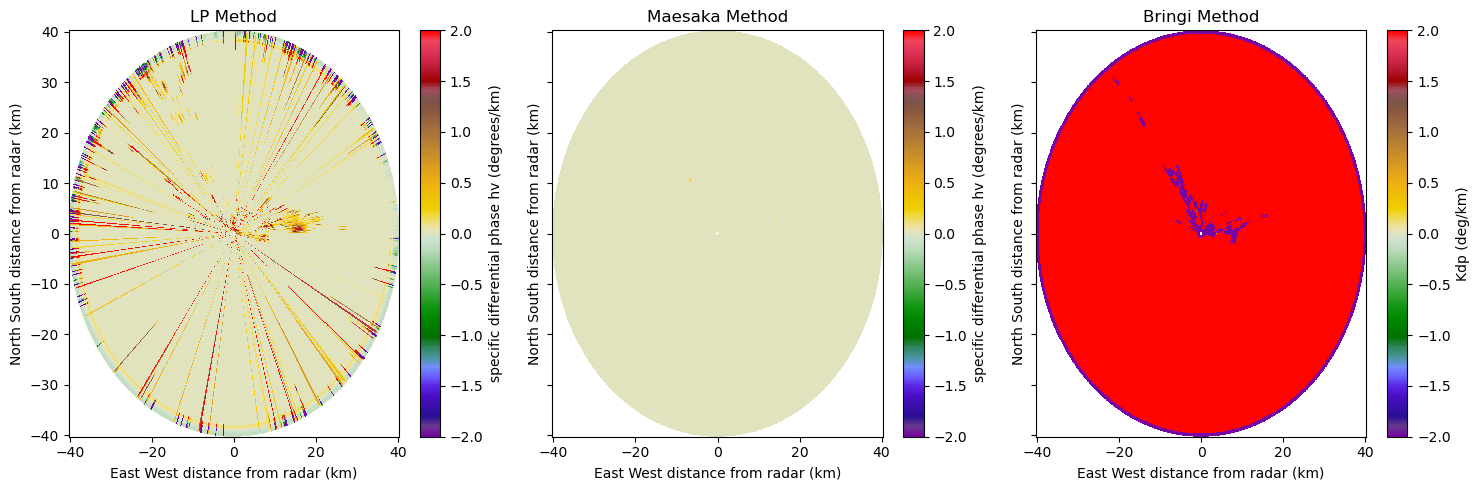

In [25]:

# Comparison
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
display = pyart.graph.RadarDisplay(radar_pyart)

# KDP LP
ax = axs[0]
display.plot('KDP_LP', 0, ax=ax, title='LP Method', vmin=-2, vmax=2, cmap='pyart_Carbone42')

# KDP Maesaka
ax = axs[1]
display.plot('KDP_maesaka', 0, ax=ax, title='Maesaka Method', vmin=-2, vmax=2, cmap='pyart_Carbone42')

# KDP Bringi
ax = axs[2]
display.plot('KDP_bringi_f', 0, ax=ax, title='Bringi Method', vmin=-2, vmax=2, cmap='pyart_Carbone42')

plt.tight_layout()
plt.show()